# Import appropriate packages

In [4]:
## Packages for data collection, exploration, and modeling
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation

## Web Scraping Packages
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
import time
import random
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chromedriver = "/Users/Carter/Desktop/chromedriver"

## to fill in missing data
from fancyimpute import KNN

## Plotting
import seaborn as sns
%matplotlib inline

/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Notice: You will notice some of the data collection cells have not been run in this notebook.  That is because I completed them in a separate notebook and then copied them here for submission.

# Part 1- Data Collection and introduction to Web Scraping


In [5]:
# initiate webdrive and add extension that blocks ads.  This increases the speed of how fast
# each html page loads
chop = webdriver.ChromeOptions()
chop.add_extension('/Users/Carter/Desktop/Adblock-Plus_v1.13.2.crx')

### Part 1 Step 1: Scrape to get URL's of all basketball players on website
#### Takes ~45 minutes to run on my machine

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

#empty array where we will store player data
player_links = []

page_letters = list("abcdefghijklmnopqrstuvwxyz")

for letter in page_letters:
    
    url = "http://www.basketball-reference.com/players/%s/" % letter
    
    browser.get(url)
    
    html = browser.page_source
    
    # grab inactive players without the strong html tag
    links = Selector(text=html).xpath("//th[@class='left ']/a/@href").extract()
    
    # then grap active players with the strong html tag
    links1 = Selector(text=html).xpath("//th[@class='left ']/strong/a/@href").extract()
    
    #combine the two separate links into one
    links = links + links1
   
    player_links.append(links)
    
    # set up random time interval to mitigate risk of being blocked by the domain
    time.sleep(2*np.random.rand())

browser.quit()

In [ ]:
# create a test links to validate data collection
test_list = player_links[:]

In [ ]:
import itertools
list2d = test_list
merged = list(itertools.chain(*list2d))

# verify list is accurate in terms of length comparted to what the website says.
# will use this link list for data collection on each player
player_links = merged[:]
len(player_links)

### Part 1 Step 2: Iterate through all links to grab each players Professional Stats
#### Takes ~3hrs on my machine to run

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

player_stats = []

print datetime.datetime.now().time()

for l in player_links:
    
    player_url = "http://www.basketball-reference.com%s" % l
    
    # get the html of the player page
    browser.get(player_url)
    
    # pull the page source so I can access the data via xpath selector
    player_html = browser.page_source
    
    # grab the name of the player
    name = Selector(text=player_html).xpath("//h1/text()").extract()
    
    player_stats.append({
        "Name": name[0],
        "Lg": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='lg_id']/text()").extract(),
        "G": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
        "GS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='gs']/text()").extract(),
        "MP": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
        "FG": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_per_g']/text()").extract(),
        "FGA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fga_per_g']/text()").extract(),
        "FG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
        "3P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_per_g']/text()").extract(),
        "3PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3a_per_g']/text()").extract(),
        "3P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
        "2P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_per_g']/text()").extract(),
        "2PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2a_per_g']/text()").extract(),
        "2P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_pct']/text()").extract(),
        "eFG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='efg_pct']/text()").extract(),
        "FT": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_per_g']/text()").extract(),
        "FTA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fta_per_g']/text()").extract(),
        "FT%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
        "ORB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='orb_per_g']/text()").extract(),
        "DRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='drb_per_g']/text()").extract(),
        "TRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
        "AST": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract(),
        "STL": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='stl_per_g']/text()").extract(),
        "BLK": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='blk_per_g']/text()").extract(),
        "TOV": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='tov_per_g']/text()").extract(),
        "PF": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pf_per_g']/text()").extract(),
        "PTS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract() 
    })
    
    time.sleep(2*np.random.rand())
    
    # put in random alert ot make sure program is still functioning correctly
    chance = (random.randint(1,100))    
    if chance <= 5:
        print ("5% chance of getting this-- still running")

print datetime.datetime.now().time()
browser.quit()

In [ ]:
# save uncleaned dataframe just in case-- this will make it so I wont have to run scrape program
# again unnecessarily
df = pd.DataFrame(player_stats)
df.shape

df.to_csv(path_or_buf= 'pro_players_v1.csv')

In [ ]:
# start work to clean up player stats
v1 = player_stats[:]

In [ ]:
# function to clean up data
for index, row in enumerate(v1):
    
    for key, value in row.items():
        
        if len(value) < 1:
            v1[index][key] = ""
        elif type(value) == list:
            v1[index][key] = value[0]
        else:
            v1[index][key] = value

In [ ]:
# cleaner dataframe now
df2 = pd.DataFrame(v1)
df2.shape

df2.to_csv(path_or_buf= 'pro_players_v2.csv')

### Part 1 Step 3: Grap advanced stats on each player.  
#### Advanced stats reside on same pages as regular stats, but have different xpaths

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

player_stats_advanced = []

print datetime.datetime.now().time()

for l in player_links:
    
    player_url = "http://www.basketball-reference.com%s" % l
    
    # get the html of the player page
    browser.get(player_url)
    
    # pull the page source so I can access the data via xpath selector
    player_html = browser.page_source
    
    # grab the name of the player
    name = Selector(text=player_html).xpath("//h1/text()").extract()
    
    player_stats_advanced.append({
        "Name": name[0],
        "PER": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='per']/text()").extract(),
        "TS%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ts_pct']/text()").extract(),
        "3PAr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fg3a_per_fga_pct']/text()").extract(),
        "FTr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fta_per_fga_pct']/text()").extract(),
        "ORB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='orb_pct']/text()").extract(),
        "DRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='drb_pct']/text()").extract(),
        "TRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='trb_pct']/text()").extract(),
        "AST%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ast_pct']/text()").extract(),
        "STL%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='stl_pct']/text()").extract(),
        "BLK%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='blk_pct']/text()").extract(),
        "TOV%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='tov_pct']/text()").extract(),
        "USG%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='usg_pct']/text()").extract(),
        "OWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ows']/text()").extract(),
        "DWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dws']/text()").extract(),
        "WS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws']/text()").extract(),
        "WS/48": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws_per_48']/text()").extract(),
        "OBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='obpm']/text()").extract(),
        "DBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dbpm']/text()").extract(),
        "BPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='bpm']/text()").extract(),
        "VORP": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='vorp']/text()").extract()
        
    })
    
    chance = (random.randint(1,100))    
    if chance <= 2:
        print ("2% chance of getting this-- still running")

print datetime.datetime.now().time()
browser.quit()

for index, row in enumerate(player_stats_advanced):
    
    for key, value in row.items():       
        if len(value) < 1:
            player_stats_advanced[index][key] = ""
        elif type(value) == list:
            player_stats_advanced[index][key] = value[0]
        else:
            player_stats_advanced[index][key] = value
            
df10 = pd.DataFrame(player_stats_advanced)
df10.to_csv(path_or_buf= 'pro_players_v2_advanced.csv')

#### Attempt to merge both DataFrames for NBA 'normal' stats and accompanying advanced stats

In [ ]:
result = pd.merge(df2, df10, how='inner', on='Name')
result.shape

In [ ]:
result.to_csv(path_or_buf= 'players_combined.csv')

### Part 1 Step Three: Grap college stats on each player.

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

college_stats = []

print datetime.datetime.now().time()

for l in player_links:
    
    player_url = "http://www.basketball-reference.com%s" % l
    
    # get the html of the player page
    browser.get(player_url)
    
    # pull the page source so I can access the data via xpath selector
    player_html = browser.page_source
    
    # grab the name of the player
    name = Selector(text=player_html).xpath("//h1/text()").extract()
    
    # check if 'college' appears on their page
    college = Selector(text=player_html).xpath("//div[@id='all_all_college_stats']/div[@class='section_heading']//h2/text()").extract()
    if not college:
        pass
    else:
        college_stats.append({
        "Name": name[0],
        "G": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
        "MP": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp']/text()").extract(),
        "FG": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg']/text()").extract(),
        "FGA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fga']/text()").extract(),
        "3P": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3']/text()").extract(),
        "3PA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3a']/text()").extract(),
        "FT": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft']/text()").extract(),
        "FTA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fta']/text()").extract(),
        "ORB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='orb']/text()").extract(),
        "TRB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb']/text()").extract(),
        "AST": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast']/text()").extract(),
        "STL": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='stl']/text()").extract(),
        "BLK": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='blk']/text()").extract(),
        "TOV": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='tov']/text()").extract(),
        "PF": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pf']/text()").extract(),
        "PTS": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts']/text()").extract(),
        "FG%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
        "3P%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
        "FT%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
        "MP_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
        "PTS_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract(),
        "TRB_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
        "AST_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract()
        
    })
        
print datetime.datetime.now().time()
browser.quit()   

for index, row in enumerate(college_stats):
    
    for key, value in row.items():       
        if len(value) < 1:
            college_stats[index][key] = ""
        elif type(value) == list:
            college_stats[index][key] = value[0]
        else:
            college_stats[index][key] = value
            
col = pd.DataFrame(college_stats)
col.to_csv(path_or_buf= 'college_stats.csv')

In [ ]:
# cleanup the list
or index, row in enumerate(college_stats):
    
    for key, value in row.items():       
        if len(value) < 1:
            college_stats[index][key] = ""
        elif type(value) == list:
            college_stats[index][key] = value[0]
        else:
            college_stats[index][key] = value

In [ ]:
col = pd.DataFrame(college_stats)
col =col.add_prefix('[C]')
col = col.rename(columns={'[C]Name': 'Name'})

### Merge Pro Stats (which now include 'normal' and advanced statistics) with college stats

In [ ]:
final = pd.merge(results, col, on='Name', how='left')

## End of copying the other Jupyter notebook into this one

#### Reading in data that was collected earler

In [4]:
nba = pd.read_csv('players_combined.csv')

In [5]:
college = pd.read_csv('college_stats.csv')

#### Add prefix on college stats to differentiate after merge

In [6]:
college.add_prefix('[C]')
college = college.rename(columns={'[C]Name': 'Name'})

### Inner join two files to get less missing data

In [7]:
print nba.shape
print college.shape

(4551, 48)
(2622, 25)


In [8]:
df_inner = pd.merge(nba, college, on='Name', how='inner')

In [9]:
df_inner.shape

(2834, 72)

In [10]:
df_inner.to_csv(path_or_buf='df_inner.csv')

In [11]:
(len(df_inner)*0.05)

141.70000000000002

In [12]:
pts = df_inner[['PTS_x','PTS_per_g']]
pts.corr()

,PTS_x,PTS_per_g
PTS_x,1.000000,0.454185
PTS_per_g,0.454185,1.000000


## Fill missing values of column if less than 40% of values are missing.  Replace with average value of that column.  I need to take this measure to run models 

In [13]:
for col in df_inner.columns:
    nulnum = df_inner[col].isnull().sum() 
    if 0 < nulnum <= (len(df_inner)*.40):
        df_inner[col].fillna(df_inner[col].mean(), inplace=True)
    

In [14]:
df_inner.shape

(2834, 72)

In [15]:
for col in df_inner.columns:
    nulnum = df_inner[col].isnull().sum()
    if nulnum > 0:
        print "stat", col, "number of empty", nulnum

stat ORB_y number of empty 2402
stat PF_y number of empty 1270
stat TOV_y number of empty 1162


### Dropping the rest of the columns that did not make cut in terms of percentage of missing data

In [16]:
data = df_inner.drop(['ORB_y', 'PF_y', 'TOV_y', 'Name', 'Lg'], axis=1)

In [17]:
y = data['PER']

In [18]:
X = data.drop('PER', axis=1)

### Left join two files to get larger amount of rows, but more missing data

In [45]:
#df_left = pd.merge(nba, college, on='Name', how='left')

In [46]:
#df_left.shape

(4671, 72)

In [23]:
#df_left.to_csv(path_or_buf='df_left.csv')

In [50]:
#df_left = df_left.dropna(axis= 0, how='all')

In [51]:
#df_left.shape

(4671, 72)

# Part 2: EDA- Initial Exploration of the Data 

#### using the DF with less missing data

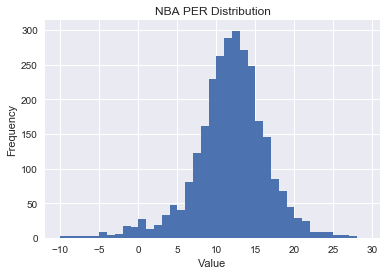

In [77]:
plt.hist(data['PER'], range(-10,30))
plt.title("NBA PER Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

fig = plt.gcf()

### Basic Scatter Plots looking at basic correlations between (1) College PPG and NBA PPG and (2) College PPG and NBA PER

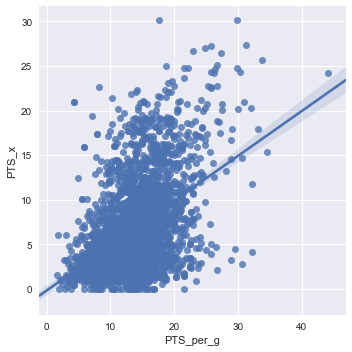

In [78]:
corr_1 = sns.lmplot(x="PTS_per_g", y="PTS_x", data=data)

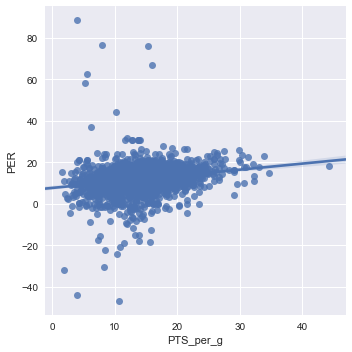

In [79]:
corr_2 = sns.lmplot(x="PTS_per_g", y="PER", data=data)

In [13]:
### Inital Regression

In [98]:
model = sm.OLS(y, X, missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PER   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     7655.
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:53:43   Log-Likelihood:                -3963.5
No. Observations:                2834   AIC:                             8059.
Df Residuals:                    2768   BIC:                             8452.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Unnamed: 0_x    -0.0015      0.001     -2.291   

### Does SK Learn yield different results?

In [99]:
lm = linear_model.LinearRegression(normalize=True).fit(X, y)
print metrics.mean_squared_error(y, lm.predict(X)), lm.score(X, y)


0.960009940387 0.97485943158


### What about different types of Regressions?

In [100]:
lm = linear_model.LinearRegression().fit(X, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'OLS R2:', lm.score(X, y)

lm = linear_model.Lasso().fit(X, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Lasso R2:', lm.score(X, y)

lm = linear_model.Ridge().fit(X, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Ridge R2:', lm.score(X, y)

~~~ OLS ~~~
OLS MSE:  0.960009940387
OLS R2: 0.97485943158
~~~ Lasso ~~~
Lasso MSE:  3.75674488186
Lasso R2: 0.901619037716
~~~ Ridge ~~~
Ridge MSE:  1.00495059842
Ridge R2: 0.973682533675


/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Grid Search makes finding correct type of regression easy

In [105]:
from sklearn import grid_search

alphas = np.logspace(-1, 1, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(X, y)


/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Use

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  0.1    ,   0.12589,   0.15849,   0.19953,   0.25119,   0.31623,
         0.39811,   0.50119,   0.63096,   0.79433,   1.     ,   1.25893,
         1.58489,   1.99526,   2.51189,   3.16228,   3.98107,   5.01187,
         6.30957,   7.94328,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [106]:
print -gs.best_score_ 
print gs.best_estimator_ 

1.49259801916
Ridge(alpha=0.39810717055349731, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


In [28]:
# knn = KNeighborsClassifier(n_neighbors=5)
# cross_val_score(knn, X1, y, cv=10, scoring='accuracy').mean()

### Due to fact that data set has so many variables, attempting PCA so reduce multicollinearity

In [45]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=4)
X_r = pca.fit_transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [ 0.56921224  0.29031321  0.06481396  0.03638333]


In [46]:
pca.explained_variance_
# below are eigan values


array([ 2321450.86649755,  1184000.99657846,   264334.50031224,
         148384.20198301])

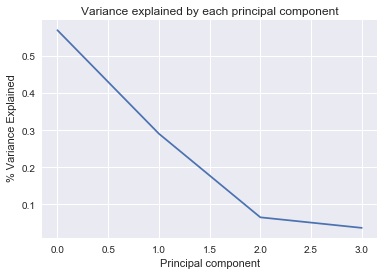

In [47]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')

#### Looks pretty good!